In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [3]:
def hist(values, title='', xlabel='Value', bins=200):
    plt.figure(figsize=(15, 5))
    plt.hist(values, bins=bins, log=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

In [4]:
def parts_hist_comparison(a, b, parts, alabel='A', blabel='B'):
    plt.figure(figsize=(15, 25))
    for (i, p) in enumerate(parts):
        plt.subplot(len(parts), 2, 2 * i + 1)
        plt.hist(a[p], bins=100, log=True)
        plt.title('{} distribution ({})'.format(p, alabel))
        plt.ylabel('Frequency')
        
        plt.subplot(len(parts), 2, 2 * i + 2)
        plt.hist(b[p], bins=100, log=True)
        plt.title('{} distribution ({})'.format(p, blabel))
        plt.ylabel('Frequency')

    plt.show()

In [5]:
pg = pd.read_csv('postgap.20171113.filtered.txt.gz', sep='\t', na_values=['None'])
print(pg.shape)
pg.head()

/Users/gpeat/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(31224438, 38)


,ld_snp_rsID,chrom,pos,afr_maf,amr_maf,eas_maf,eur_maf,sas_maf,gene_symbol,gene_id,...,vep_sum,vep_mean,GTEx,VEP,Fantom5,DHS,PCHiC,Nearest,Regulome,VEP_reg
0,rs10740053,10,63702584,0.7784,0.5317,0.6736,0.6928,0.4888,CISD1,ENSG00000122873,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009814,0.0,0.0,0
1,rs10740054,10,63702586,0.7784,0.5317,0.6736,0.6928,0.4877,IPMK,ENSG00000151151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009814,0.0,0.0,0
2,rs10740053,10,63702584,0.7784,0.5317,0.6736,0.6928,0.4888,IPMK,ENSG00000151151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009814,0.0,0.0,0
3,rs4506592,10,63727187,0.7020,0.5101,0.6538,0.6511,0.4785,IPMK,ENSG00000151151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.008807,0.0,0.0,0
4,rs11332367,10,63736618,0.8396,0.5303,0.6448,0.6700,0.4826,RTKN2,ENSG00000182010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.007876,0.0,0.0,0


In [ ]:
# ## Issue 1: Abundance of SNPs
# In the GWAS Catalogue data (pre-POSTGAP) currently displayed in the platform, there are approximately 60000 SNPs. POSTGAP brings significantly more (approximately 800000) as can be seen below.
# pk_minus_ld_snp = ['gwas_snp', 'gene_id', 'disease_efo_id', 'gwas_pmid']
# groups = pg.groupby(pk_minus_ld_snp)
# row_counts = groups.size()
# unique_snp_counts = groups['ld_snp_rsID'].nunique()

# print('Number of (lead snp, gene, disease, pmid) groups: {}'.format(row_counts.shape))
# hist(row_counts, title='Histogram of row counts per (lead snp, gene, disease, pmid)', xlabel='Rows associated')
# hist(unique_snp_counts, title='Histogram of unique ld snp counts per (lead snp, gene, disease, pmid)', xlabel='Unique SNPs')

## Issue 2: No data for X, Y chromosomes
The latest POSTGAP file contains no data for SNPs on the X or Y chromosomes and no data for genes on the Y chromosome.

In [10]:
# fields 2, 10 are snp chromosome and gene chromosome respectively
# confirmed with:
#   `gzcat postgap.20171113.filtered.txt.gz | cut -f2 | sort | uniq`
#   `gzcat postgap.20171113.filtered.txt.gz | cut -f10 | sort | uniq`
print('Chromomsomes covered by POSTGAP SNPs: {}'.format(pg.chrom.unique()))
print('Chromomsomes covered by POSTGAP genes: {}'.format(pg.gene_chrom.astype(str).unique()))

Chromomsomes covered by POSTGAP SNPs: [10 12 14  9  7 15  8 11 19  4  3 16  5  6 13  1  2 18 20 22 17 21]
Chromomsomes covered by POSTGAP genes: ['10' '12' '14' '9' '7' '15' '8' '11' '19' '4' '3' '16' '5' '6' '13' '1'
 '2' '18' '20' '22' '17' '21' 'X']


## Issue 3: SNPs and genes on different chromosomes
POSTGAP contains entries where the SNP and gene are on different chromosomes. Is this expected? Should these rows be filtered out?

In [7]:
geo = pg.groupby(['gene_id', 'ld_snp_rsID']).first()
geo = geo[['gene_tss', 'gene_chrom', 'pos', 'chrom']]
chrom_mismatches = (geo.gene_chrom.astype(str) != geo.chrom.astype(str))
print('{} of {} unique gene-SNP pairs have difference between gene and SNP chromosome'.format(chrom_mismatches[chrom_mismatches == True].count(), len(geo)))

2378 of 8226315 unique gene-SNP pairs have difference between gene and SNP chromosome


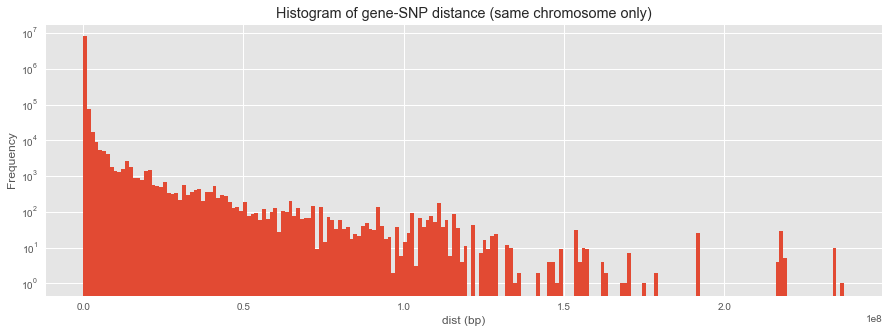

In [11]:
geo_chrom_matches = geo[chrom_mismatches == False]
d = np.absolute(geo_chrom_matches.pos - geo_chrom_matches.gene_tss)
hist(d, title='Histogram of gene-SNP distance (same chromosome only)', xlabel='dist (bp)')

In [12]:
print('{} of {} gene-SNP distances are over 1Mbp apart (when on the same chromosome)'.format(len(d[d > 1000000]), len(d)))
print('{} of {} gene-SNP distances are over 10Mbp apart (when on the same chromosome)'.format(len(d[d > 10000000]), len(d)))
print('{} of {} gene-SNP distances are over 100Mbp apart (when on the same chromosome)'.format(len(d[d > 100000000]), len(d)))

171306 of 8223937 gene-SNP distances are over 1Mbp apart (when on the same chromosome)
25896 of 8223937 gene-SNP distances are over 10Mbp apart (when on the same chromosome)
1144 of 8223937 gene-SNP distances are over 100Mbp apart (when on the same chromosome)


**Question**: Which part(s) of the score contribute to gene-SNP associations with distances over 5Mbp?

In [13]:
far_apart = d[d > 5000000].reset_index(['gene_id', 'ld_snp_rsID'])[['gene_id', 'ld_snp_rsID']]
nearby = d[d <= 5000000].reset_index(['gene_id', 'ld_snp_rsID'])[['gene_id', 'ld_snp_rsID']]

In [14]:
score_parts = ['score', 'VEP', 'Regulome', 'PCHiC', 'GTEx', 'Fantom5', 'DHS', 'Nearest']
far_apart_scores = pd.merge(far_apart, pg[['gene_id', 'ld_snp_rsID', *score_parts]], on=('gene_id', 'ld_snp_rsID'))

In [15]:
nearby_scores = pd.merge(nearby, pg[['gene_id', 'ld_snp_rsID', *score_parts]], on=('gene_id', 'ld_snp_rsID'))

In [16]:
far_apart_scores.head()

,gene_id,ld_snp_rsID,score,VEP,Regulome,PCHiC,GTEx,Fantom5,DHS,Nearest
0,ENSG00000001167,rs34488826,0.0,0.0,0.0,0.009057,0.0,0.0,0.0,0.0
1,ENSG00000001167,rs35147300,0.5,0.0,0.5,0.009057,0.0,0.0,0.0,0.0
2,ENSG00000001167,rs4959235,0.0,0.0,0.0,0.008658,0.0,0.0,0.0,0.0
3,ENSG00000001167,rs71551042,0.5,0.0,0.5,0.009057,0.0,0.0,0.0,0.0
4,ENSG00000001167,rs72098212,0.0,0.0,0.0,0.009057,0.0,0.0,0.0,0.0


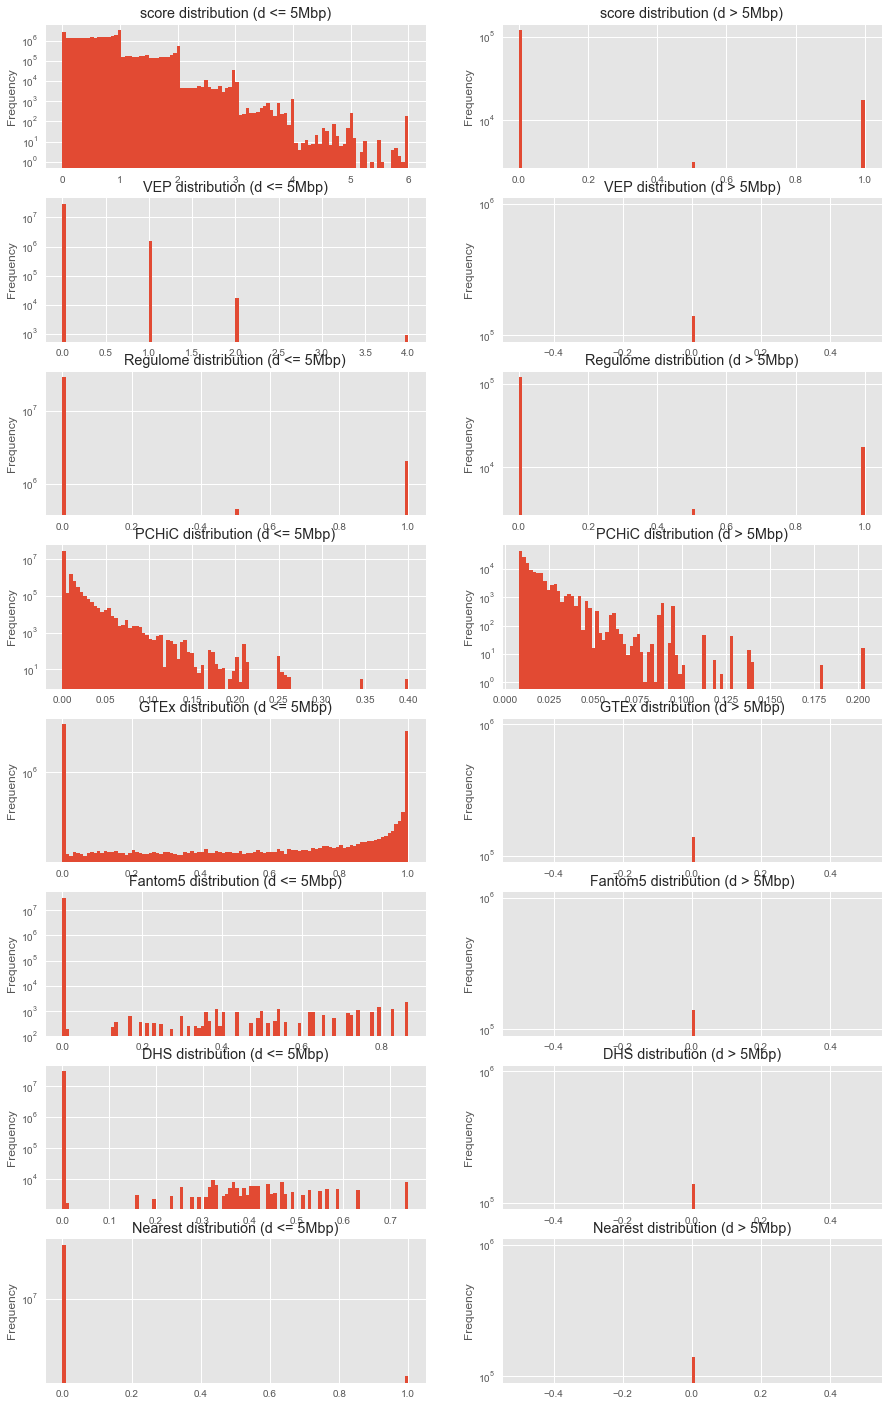

In [17]:
parts_hist_comparison(nearby_scores, far_apart_scores, score_parts, alabel='d <= 5Mbp', blabel='d > 5Mbp')

**Question**: Which part(s) of the score contribute to gene-SNP associations with differing chromosomes?

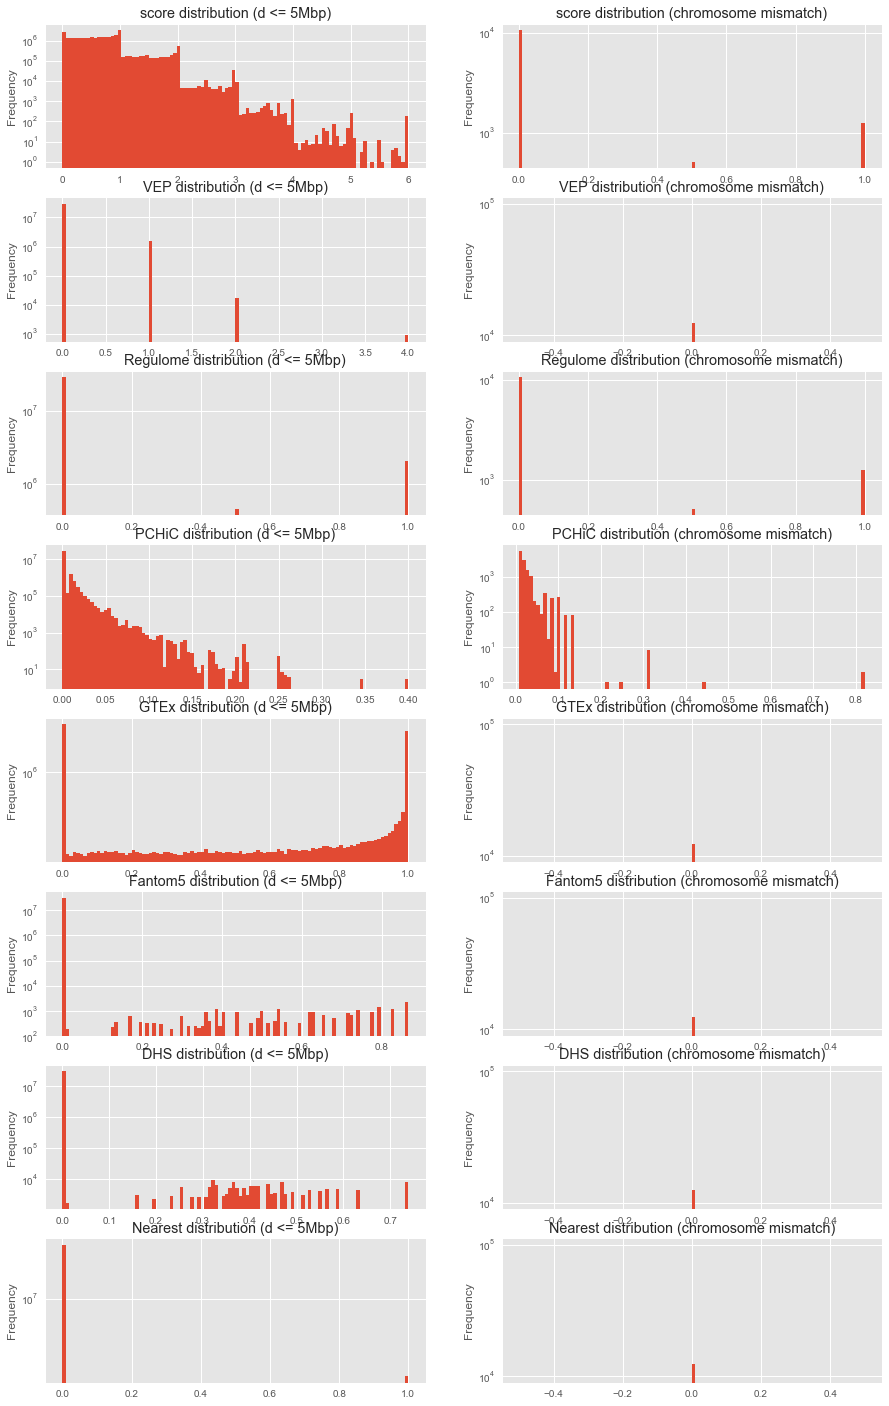

In [20]:
geo_chrom_mismatches = geo[chrom_mismatches == True]
d_mismatches = np.absolute(geo_chrom_mismatches.pos - geo_chrom_mismatches.gene_tss)
chom_mismatch_cols = d_mismatches[d_mismatches > 5000000].reset_index(['gene_id', 'ld_snp_rsID'])[['gene_id', 'ld_snp_rsID']]
chrom_mismatch_scores = pd.merge(chom_mismatch_cols, pg[['gene_id', 'ld_snp_rsID', *score_parts]], on=('gene_id', 'ld_snp_rsID'))
parts_hist_comparison(nearby_scores, chrom_mismatch_scores, score_parts, alabel='d <= 5Mbp', blabel='chromosome mismatch')